In [2]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.inf)

# Problema: Equação de Condução de Calor em duas dimensões

$$\frac{\partial^2 T}{\partial x^2}+\frac{\partial^2 T}{\partial y^2}=-\frac{A_0}{k}=-40$$

com $0\leq x\leq 10$ e $0\leq y \leq 10$ e com condição de contorno

$$ k\frac{\partial T}{\partial n}=H(T-T_\infty) \Rightarrow  -k\frac{\partial T}{\partial n} = -HT+HT_\infty$$

In [40]:
A0 = 100.
k = 2.5
H0 = 5.6
Tinf = 300.
Hc = -A0#/k
Ak = -H0/k
Fk = -H0*Tinf/k

In [41]:
def cramer(n,N):
    for e in xrange(n.shape[0]):
        A = np.array([[1,n[e,0,0],n[e,0,1]],
                      [1,n[e,1,0],n[e,1,1]],
                      [1,n[e,2,0],n[e,2,1]]])
        detA = np.linalg.det(A)
        
        for i in xrange(3):
            a = np.copy(A)
            a[:,i] = np.array([1,0,0])
            b = np.copy(A)
            b[:,i] = np.array([0,1,0])
            c = np.copy(A)
            c[:,i] = np.array([0,0,1])
            
            N[e,0,i] = np.linalg.det(a) / detA
            N[e,1,i] = np.linalg.det(b) / detA
            N[e,2,i] = np.linalg.det(c) / detA

    return N

def derivada(N):
    dN = np.zeros(shape=(N.shape[0],2,3))
    for e in xrange(N.shape[0]):
        dN[e,0] = N[e,:,1]
        dN[e,1] = N[e,:,2]
    return dN

def rigidez(n,dN,k):
    K = np.zeros(shape=(dN.shape[0],3,3))
    for e in xrange(dN.shape[0]):
        A = np.array([[1,n[e,0,0],n[e,0,1]],
                      [1,n[e,1,0],n[e,1,1]],
                      [1,n[e,2,0],n[e,2,1]]])
        detA = np.linalg.det(A)
        
        for i in xrange(3):
            for j in xrange(3):
                aux1 = dN[e,0,j] * dN[e,0,i]
                aux2 = dN[e,1,j] * dN[e,1,i]
                K[e,i,j] = (-0.5*detA) * k * (aux1+aux2)
    return K

def calcIntegral(y,dx):
    aux = y[1:-1] * dx
    r = np.sum(aux)
    r = r + (y[0]*dx/2.) + (y[-1]*dx/2.)
    return r

# Geometria 

In [42]:
nx, ny = 30, 30

N_eleme = 2 * (nx-1) * (ny-1)
N_nodes = nx * ny
N_quad = N_eleme / 2
N_front = ((nx-1)*2) + ((ny-1)*2)

xx = np.linspace(0,10,nx)
yy = np.linspace(0,10,ny)
x = np.tile(xx,ny)
y = np.tile(yy,nx)
n = np.zeros(shape=(N_eleme,3,2))

e = 0
for j in xrange(ny-1):
    for i in xrange(nx-1):
        n[e,0] = np.array([x[1+i],y[1+j]])
        n[e,1] = np.array([x[0+i],y[1+j]])
        n[e,2] = np.array([x[0+i],y[0+j]])
        n[e+1,0] = np.array([x[1+i],y[1+j]])
        n[e+1,1] = np.array([x[0+i],y[0+j]])
        n[e+1,2] = np.array([x[1+i],y[0+j]])
        e+=2
        
N = np.zeros(shape=(N_eleme,3,3))
N = cramer(n,N)
dN = derivada(N)

# Elementos Interiores

In [43]:
################################################################################
# [POS] Matriz das Posições
################################################################################

POS = np.zeros(shape=(N_eleme+1,2))

for j in xrange(ny):
    for i in xrange(nx):
        POS[i+(j*nx),0] = xx[i]
        POS[i+(j*nx),1] = yy[j]
        
################################################################################        
# [CON] Matriz de conectividade
################################################################################

CON = np.zeros(shape=(N_eleme,3))

for e in xrange(N_eleme):
    CON[e,0] = int(np.where((POS[:,0]==n[e,0,0])&(POS[:,1]==n[e,0,1]))[0][0])
    CON[e,1] = int(np.where((POS[:,0]==n[e,1,0])&(POS[:,1]==n[e,1,1]))[0][0])
    CON[e,2] = int(np.where((POS[:,0]==n[e,2,0])&(POS[:,1]==n[e,2,1]))[0][0])

################################################################################    
# [KL] Matriz de rigidez local     
################################################################################

KL = rigidez(n,dN,k)

################################################################################
# [FL] Vetor de carga local 
################################################################################

# Centroide
CL = np.zeros(shape=(N_eleme,3))
for e in xrange(N_eleme):
    A = np.array([[1,n[e,0,0],n[e,0,1]],
                  [1,n[e,1,0],n[e,1,1]],
                  [1,n[e,2,0],n[e,2,1]]])
    detA = np.linalg.det(A)
        
    CL[e,0] = (n[e,0,0]+n[e,1,0]+n[e,2,0]) / 3.
    CL[e,1] = (n[e,0,1]+n[e,1,1]+n[e,2,1]) / 3.
    CL[e,2] = detA / 2.0

FL = np.zeros(shape=(N_eleme,3))
for e in xrange(N_eleme):
    FL[e,0] = Hc * CL[e,2] * (N[e,0,0]+(N[e,0,1]*CL[e,0])+(N[e,0,2]*CL[e,1]))
    FL[e,1] = Hc * CL[e,2] * (N[e,1,0]+(N[e,1,1]*CL[e,0])+(N[e,1,2]*CL[e,1]))
    FL[e,2] = Hc * CL[e,2] * (N[e,2,0]+(N[e,2,1]*CL[e,0])+(N[e,2,2]*CL[e,1]))

# Elementos de Fronteira

In [44]:
################################################################################
# [POF] Posição dos elementos de fronteira
################################################################################

POF = np.zeros(shape=(N_front,2))

POF[0,0] = xx[0]
POF[1:nx-1,0] = xx[1:nx-1]
POF[nx-1,0] = xx[-1]
POF[nx:nx+ny-2,0] = xx[-1]
POF[nx+ny-2,0] = xx[-1]
POF[nx+ny-1:nx+ny+nx-3,0] = xx[nx-2:0:-1]
POF[nx+ny+nx-3,0] = xx[0]
POF[nx+ny+nx-2:,0] = xx[0]

POF[0,1] = yy[0]
POF[1:nx-1,1] = yy[0]
POF[nx-1,1] = yy[0]
POF[nx:nx+ny-2,1] = yy[1:-1]
POF[nx+ny-2,1] = yy[-1]
POF[nx+ny-1:nx+ny+nx-3,1] = yy[-1]
POF[nx+ny+nx-3,1] = yy[-1]
POF[nx+ny+nx-2:,1] = yy[nx-2:0:-1]

################################################################################
# [COF]  Matriz de conectividade entre os pontos de fronteira
################################################################################

COF = np.zeros(shape=(N_front,2))
for e in xrange(N_front):
    cx = np.where((POS[:,0]==POF[e,0])&(POS[:,1]==POF[e,1]))[0][0]
    try:
        cy = np.where((POS[:,0]==POF[e+1,0])&(POS[:,1]==POF[e+1,1]))[0][0]
    except:
        cy = np.where((POS[:,0]==POF[0,0])&(POS[:,1]==POF[0,1]))[0][0]
    COF[e,0] = int(cx)
    COF[e,1] = int(cy)
    
################################################################################    
# [KF] Matriz de Rigidez para os elementos de Fronteira
################################################################################

KF = np.zeros(shape=(N_front,2,2))

dx = xx[1] - xx[0]
dx2 = (xx[1]-xx[0])**2
s = np.sqrt(dx2)
xi = np.linspace(xx[0],xx[1],101)
dxi = xi[1]-xi[0]
Bn = (xi/s)

for e in xrange(N_front):
    KF[e,0,0] = Ak * calcIntegral((1-Bn)*(1-Bn),dxi) 
    KF[e,0,1] = Ak * calcIntegral((1-Bn)*Bn,dxi)
    KF[e,1,0] = Ak * calcIntegral(Bn*(1-Bn),dxi)
    KF[e,1,1] = Ak * calcIntegral(Bn*Bn,dxi)

################################################################################
# [FCL] Vetor de carga dos elementos de fronteira
################################################################################
    
FCL = np.zeros(shape=(N_front,2))

for e in xrange(N_front):
    FCL[e,0] = Fk * calcIntegral((1-Bn),dxi) 
    FCL[e,1] = Fk * calcIntegral(Bn,dxi) 

# Matriz Global

In [45]:
################################################################################
# [K] Matriz de rigidez global 
################################################################################

K = np.zeros(shape=(N_nodes,N_nodes))

# Elementos interiores
h = np.zeros(N_nodes)

for e in xrange(N_eleme):
    cont0 = 0
    for node_x in CON[e]:
        cont1 = 0
        aux = int(node_x)
        h[aux] = h[aux] + FL[e,cont0]
        for node_y in CON[e]:
            i,j = int(node_x),int(node_y)
            K[i,j] = K[i,j] + KL[e,cont0,cont1]
            cont1 += 1
        cont0 += 1

# Elementos de fronteira
f = np.zeros(N_nodes)

for e in xrange(N_front):
    cont0 = 0
    for node_x in COF[e]:
        cont1 = 0
        aux = int(node_x)
        f[aux] = f[aux] + FCL[e,cont0]
        for node_y in COF[e]:
            i,j = int(node_x),int(node_y)
            K[i,j] = K[i,j] + KF[e,cont0,cont1]
            cont1 += 1
        cont0 += 1

################################################################################
# [H] Vetor de carga global
################################################################################

H = h + f

# Solução

In [46]:
c = np.linalg.solve(K,H)

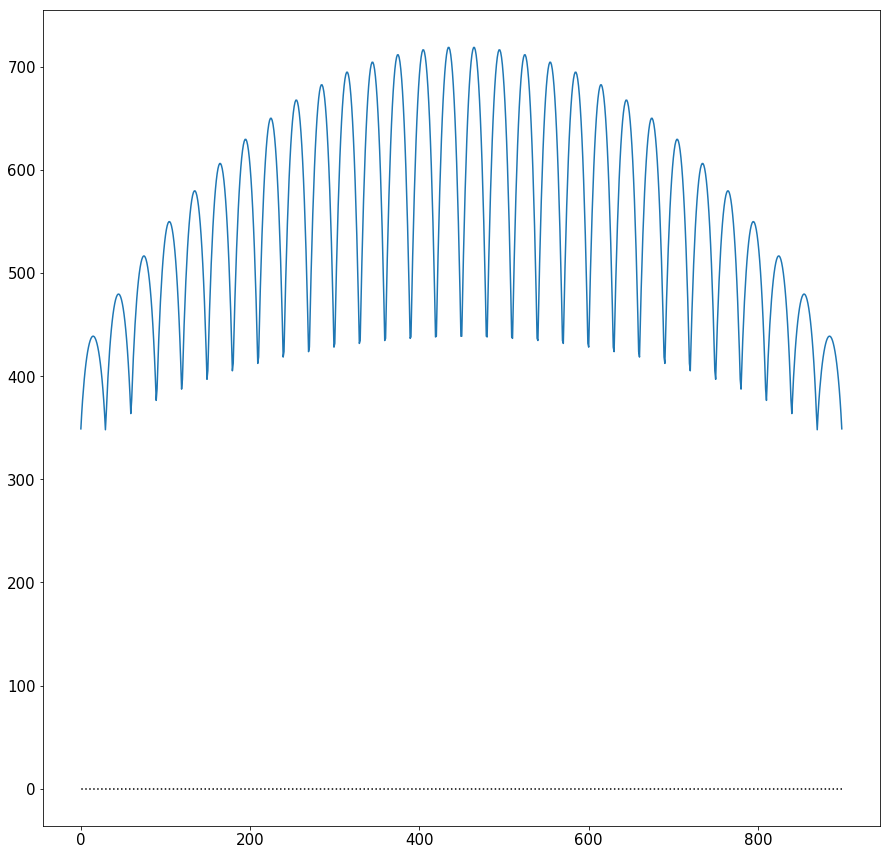

In [47]:
lettersize = 15
plt.rcParams.update({'font.size': lettersize})
plt.figure(figsize=(15,15))
plt.plot(c,"-")
plt.hlines(0,c.size-1,0,linestyles="dotted")

349.0120000363006 349.01200003630015 348.116482888868 718.8544664632545


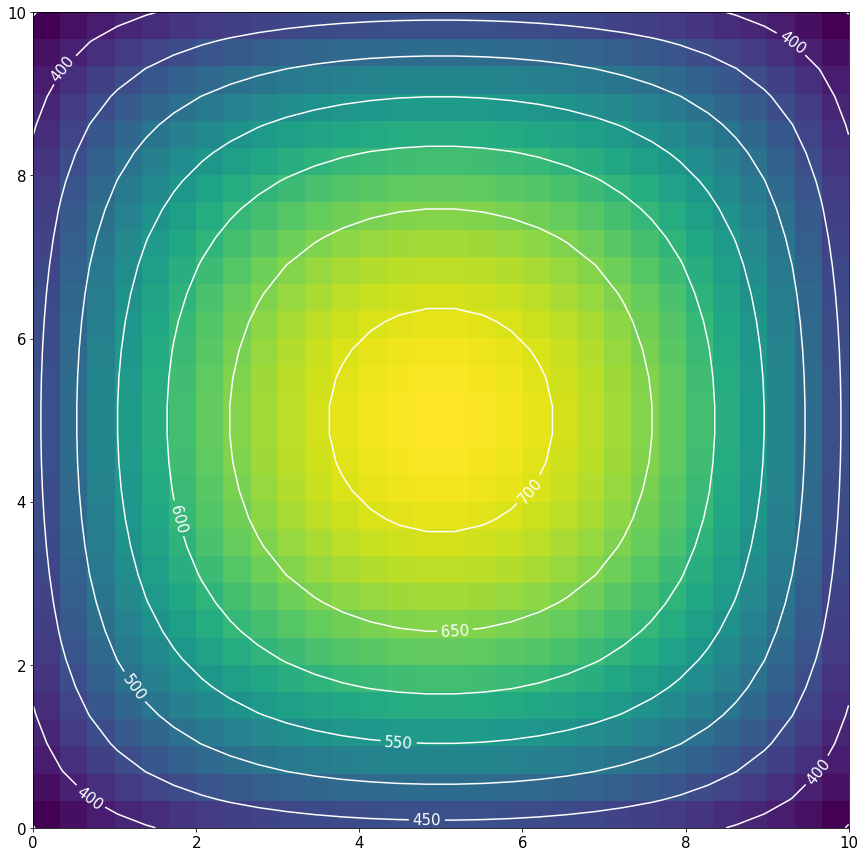

In [48]:
plt.figure(figsize=(15,15))
plt.imshow(c.reshape(nx,ny),extent=[0,10,0,10])
CS = plt.contour(c.reshape(nx,ny),extent=[0,10,0,10],colors='w')
plt.clabel(CS,inline=1,fmt='%1.0f',fontsize=lettersize)
print c[0], c[-1], np.min(c), np.max(c)

In [14]:
POF

array([[ 0.,  0.],
       [ 5.,  0.],
       [10.,  0.],
       [10.,  5.],
       [10., 10.],
       [ 5., 10.],
       [ 0., 10.],
       [ 0.,  5.]])